In [1]:
# 標準
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL
# 自作
import my_function
import time_dependent_tree
import graft_regression_tree

In [2]:
np.random.seed(314) # 乱数シードを314に設定
# 合成波の作成
syn_t = my_function.make_wave(0.5, 1.0, 3.0, 100)[0]
syn_y = my_function.make_wave(0.5, 1.0, 3.0, 100)[1] + my_function.make_wave(0.75, 1.7, 3.0, 100)[1] + 0.05 * np.random.randn(len(syn_t))

In [3]:
# STL分解
stl=STL(syn_y, period=12, robust=True)
stl_series = stl.fit()
# STL分解結果のグラフ化
"""
plt.rcParams['figure.figsize'] = [12, 9]
stl_series.plot()
plt.show()
"""

"\nplt.rcParams['figure.figsize'] = [12, 9]\nstl_series.plot()\nplt.show()\n"

In [4]:
# データの整形
raw_x, raw_y = my_function.sliding_window(syn_y)
trend_x, trend_y = my_function.sliding_window(stl_series.trend)
seasonal_x, seasonal_y = my_function.sliding_window(stl_series.seasonal)
resid_x, resid_y = my_function.sliding_window(stl_series.resid)

# データの分割
raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split(raw_x, raw_y, test_size=0.1, shuffle=False)
trend_x_train, trend_x_test, trend_y_train, trend_y_test = train_test_split(trend_x, trend_y, test_size=0.1, shuffle=False)
seasonal_x_train, seasonal_x_test, seasonal_y_train, seasonal_y_test = train_test_split(seasonal_x, seasonal_y, test_size=0.1, shuffle=False)
resid_x_train, resid_x_test, resid_y_train, resid_y_test = train_test_split(resid_x, resid_y, test_size=0.1, shuffle=False)

In [5]:
# インスタンス生成
trend_tdtree = time_dependent_tree.TimeDependentTree(trend_x_train, raw_y_train, max_depth=5, min_samples_leaf=5)
seasonal_tdtree = time_dependent_tree.TimeDependentTree(seasonal_x_train, raw_y_train, max_depth=5, min_samples_leaf=5)
resid_tdtree = time_dependent_tree.TimeDependentTree(resid_x_train, raw_y_train, max_depth=5, min_samples_leaf=5)

# 学習
trend_tdtree.train()
seasonal_tdtree.train()
resid_tdtree.train()

# 予測
trend_train_pred = trend_tdtree.predict(trend_x_train)
trend_test_pred = trend_tdtree.predict(trend_x_test)
seasonal_train_pred = seasonal_tdtree.predict(seasonal_x_train)
seasonal_test_pred = seasonal_tdtree.predict(seasonal_x_test)
resid_train_pred = resid_tdtree.predict(resid_x_train)
resid_test_pred = resid_tdtree.predict(resid_x_test)

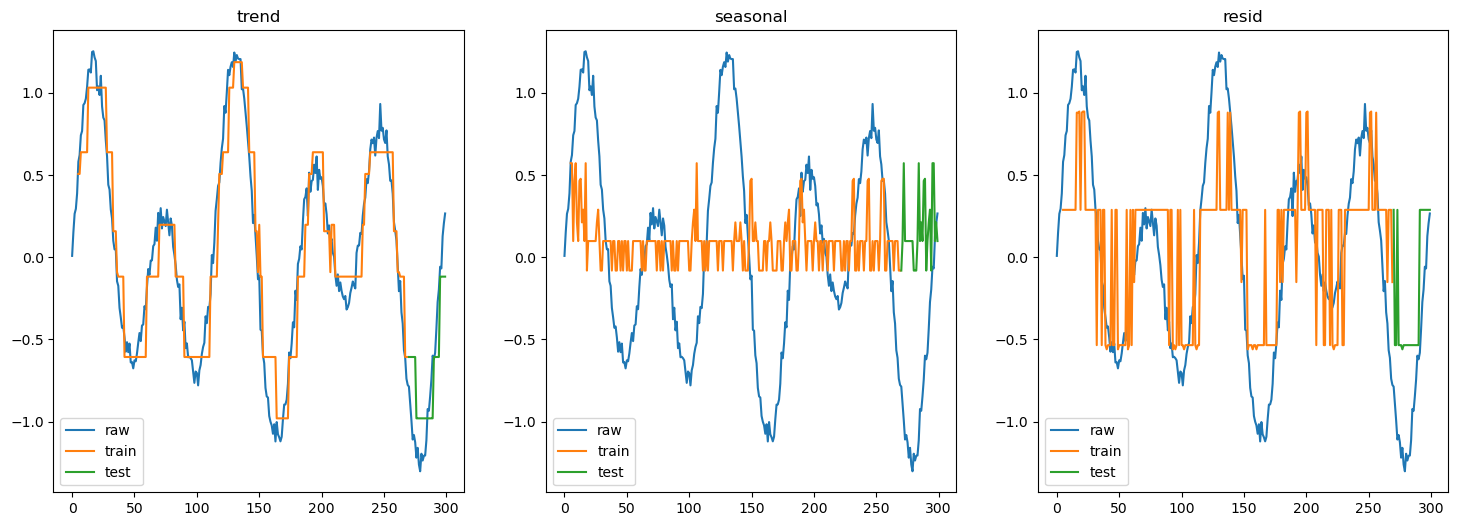

In [14]:
# 時間依存木の予測結果の描画

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(range(0, len(syn_y)), syn_y, label='raw')
ax1.plot(range(5, len(trend_train_pred)+5), trend_train_pred, label='train')
ax1.plot(range(len(syn_y)-len(trend_test_pred), len(syn_y)), trend_test_pred, label='test')
ax1.set_title('trend')
ax1.legend()

ax2.plot(range(0, len(syn_y)), syn_y, label='raw')
ax2.plot(range(5, len(seasonal_train_pred)+5), seasonal_train_pred, label='train')
ax2.plot(range(len(syn_y)-len(seasonal_test_pred), len(syn_y)), seasonal_test_pred, label='test')
ax2.set_title('seasonal')
ax2.legend()

ax3.plot(range(0, len(syn_y)), syn_y, label='raw')
ax3.plot(range(5, len(resid_train_pred)+5), resid_train_pred, label='train')
ax3.plot(range(len(syn_y)-len(resid_test_pred), len(syn_y)), resid_test_pred, label='test')
ax3.set_title('resid')
ax3.legend()

plt.show()

In [7]:
# データのまとめ
x_train_ls = [trend_x_train, seasonal_x_train, resid_x_train]
x_test_ls = [trend_x_test, seasonal_x_test, resid_x_test]
tdtree_ls = [trend_tdtree, seasonal_tdtree, resid_tdtree]

In [8]:
# インスタンス生成
grtree = graft_regression_tree.GraftRegressionTree(raw_y_test, tdtree_ls)

# 再構成
grtree.build_tree(target_depth=0, tdtree_index=0)
grtree.build_tree(target_depth=1, tdtree_index=0)
grtree.build_tree(target_depth=2, tdtree_index=1)
grtree.build_tree(target_depth=3, tdtree_index=0)
grtree.build_tree(target_depth=4, tdtree_index=0)
grtree.check_structure()

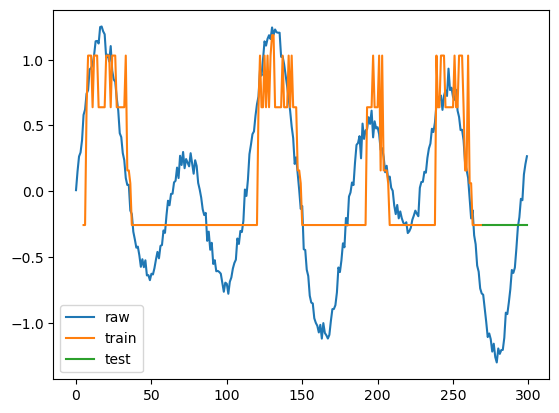

In [11]:
grtree_train_pred = grtree.predict(x_train_ls)
grtree_test_pred = grtree.predict(x_test_ls)
plt.plot(range(0, len(syn_y)), syn_y, label='raw')
plt.plot(range(5, len(grtree_train_pred)+5), grtree_train_pred, label='train')
plt.plot(range(len(syn_y)-len(grtree_test_pred), len(syn_y)), grtree_test_pred, label='test')
plt.legend()
plt.show()